In [1]:
import cv2
from utils import show_images,calculate_distance
import math
import numpy as np
from skimage.draw import line
from sklearn.metrics.pairwise import euclidean_distances

%load_ext autoreload
%autoreload 2
%matplotlib inline
 

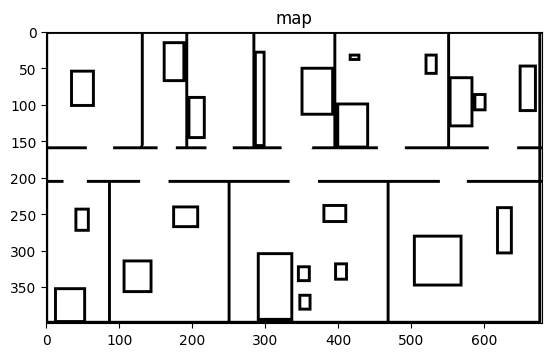

In [2]:
# Read Map
img = cv2.imread("./map.jpeg", cv2.IMREAD_COLOR)
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Convert to binary
threshold_value = 128
_, map = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), threshold_value, 1, cv2.THRESH_BINARY)

show_images([map],['map'])


# Problem (1)

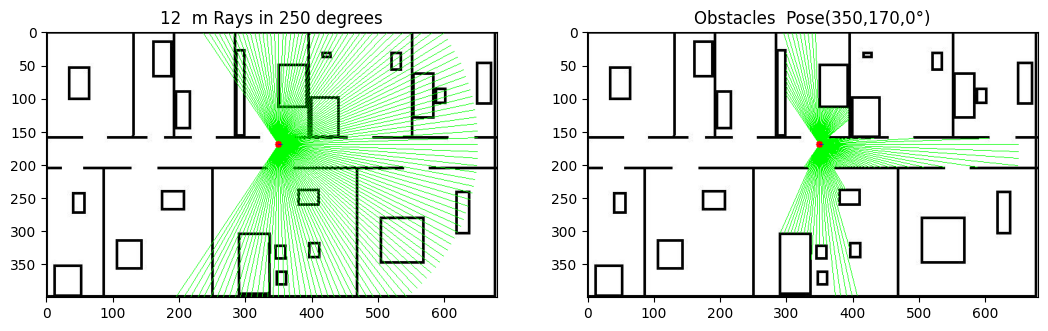

(126,)


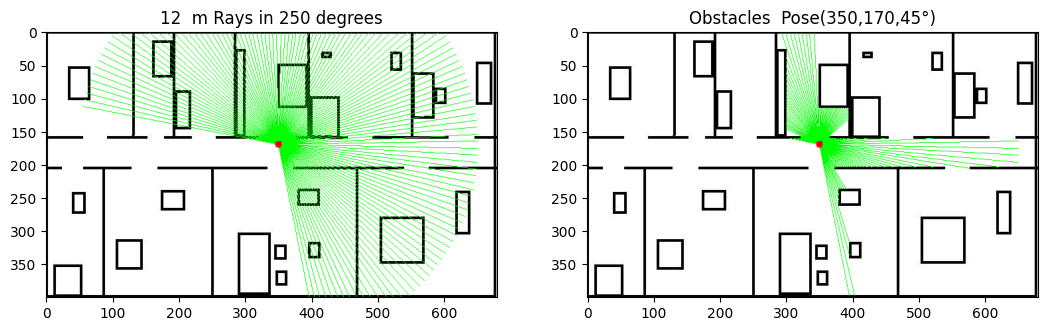

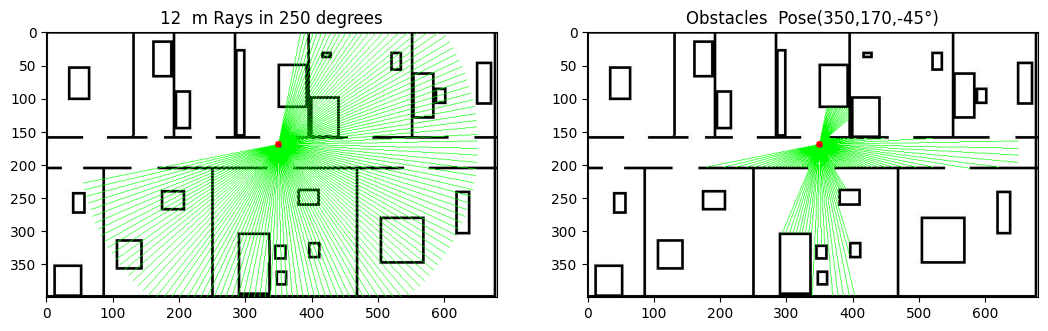

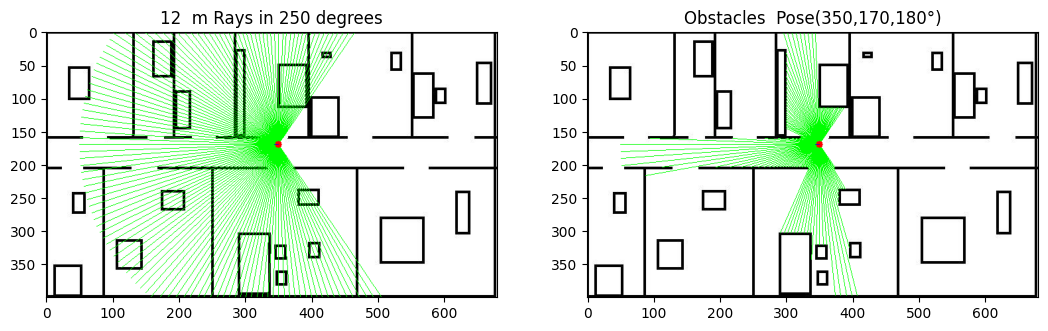

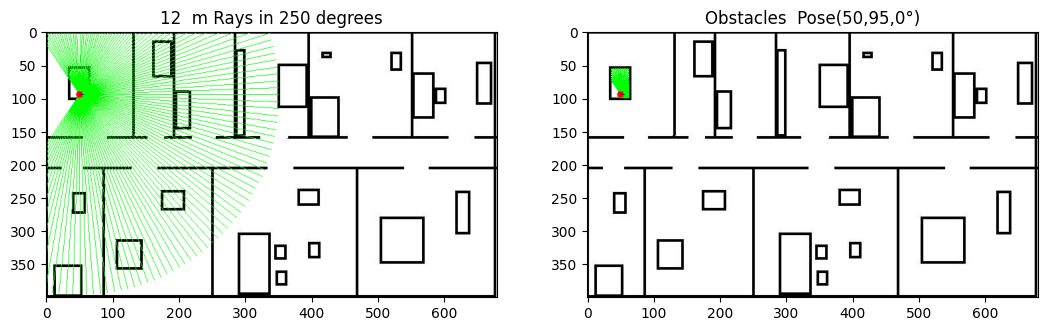

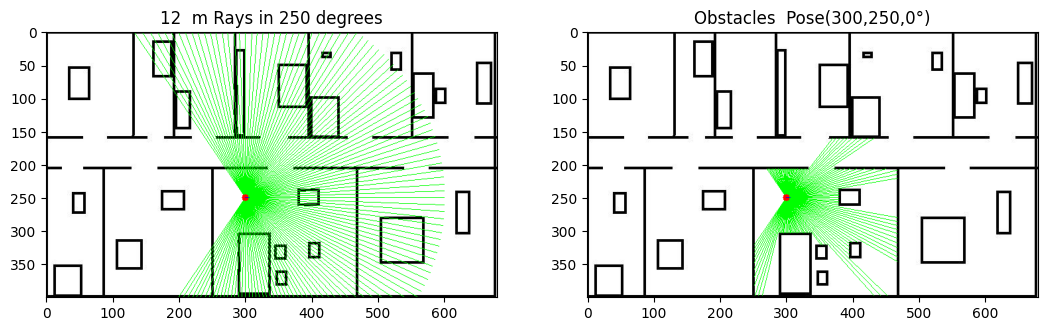

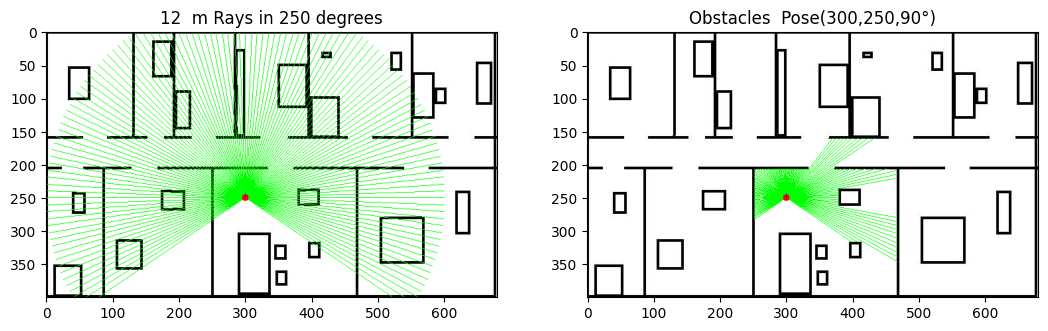

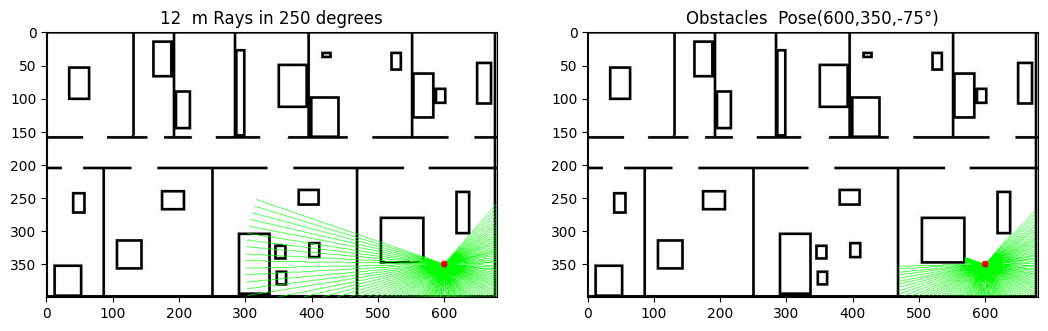

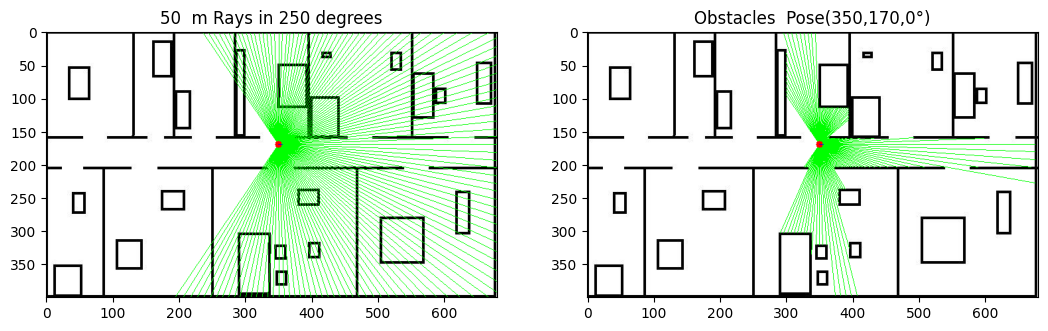

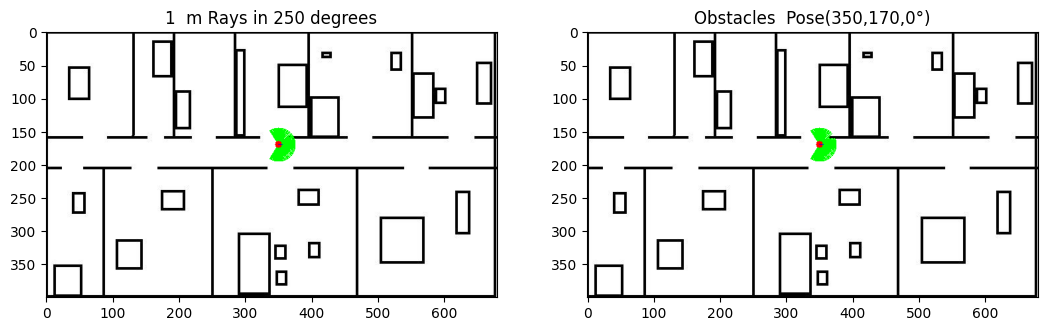

In [4]:
def laser_range(map,initial_pose,max_range=1200,debug=True):
    H,W=map.shape

    # Robot initial Pose
    x=initial_pose[0] # pixel 400
    y=initial_pose[1]  # pixel 170
    theta=initial_pose[2]
    theta_rad = math.radians(-1*theta)

    # Ray
    # max_range=1200 #12m =1200 cm
    ray_angle=2

    full_range_ray_map=img.copy()

    max_range_ray_map=full_range_ray_map.copy()


    # distances_left=np.array([])
    # distances_right=np.array([])
    distances=np.array([])


    # Go 125 Degrees right and left on ray_angle=2 degrees at each step
    for i in range(0,125,ray_angle):
    # for i in range(2,3,ray_angle):        
            

        # Right
        new_theta_rad = math.radians(-1*theta+i)
        # Calculate the new x and y coordinates
        max_x = math.ceil((x*4 + max_range * math.cos(new_theta_rad))/4)
        max_y = math.ceil((y*4 + max_range * math.sin(new_theta_rad))/4)

        # Draw Full Range Ray
        cv2.line(full_range_ray_map, (x, y), (max_x, max_y), (0,255,0), 1)

        # Get Ray Points
        points_x,points_y=line( x, y, max_x, max_y)

        # Drop those out of the Map Boundaries
        valid_indices = np.where((points_x < W)&(points_x >= 0) & (points_y < H)&(points_y >= 0))[0]
        points_x=points_x[valid_indices]
        points_y=points_y[valid_indices]

        # Get Obstacles
        first_obstacle_index=np.where(map[points_y,points_x] == 0)[0]
        if(len(first_obstacle_index)>0):
            first_obstacle_index=first_obstacle_index[0] #first zero Pixel
            first_obstacle=(points_x[first_obstacle_index],points_y[first_obstacle_index])
        else:
            # Not obstacle but max_range ray :D
            first_obstacle=(max_x,max_y) 


        # Compute Distance
        distance = calculate_distance(x,y,first_obstacle[0],first_obstacle[1])*4
        # distances_right=np.append(distances_right,distance)
        distances=np.append(distances,distance)

        # Draw Ray Till First Obstacle
        cv2.line(max_range_ray_map, (x, y), first_obstacle, (0,255,0), 1)
          

        # Left
        new_theta_rad = math.radians(-1*theta-i)
        # Calculate the new x and y coordinates
        max_x = math.ceil((x*4 + max_range * math.cos(new_theta_rad))/4)
        max_y = math.ceil((y*4 + max_range * math.sin(new_theta_rad))/4)

        # Draw Full Range Ray
        cv2.line(full_range_ray_map, (x, y), (max_x, max_y), (0,255,0), 1)

        # Get Ray Points
        points_x,points_y=line( x, y, max_x, max_y)
        
        # Drop those out of the Map Boundaries
        valid_indices = np.where((points_x < W)&(points_x >= 0) & (points_y < H)&(points_y >= 0))[0]
        points_x=points_x[valid_indices]
        points_y=points_y[valid_indices]

        # Get Obstacles
        first_obstacle_index=np.where(map[points_y,points_x] == 0)[0]
        if(len(first_obstacle_index)>0):
            first_obstacle_index=first_obstacle_index[0] #first zero Pixel
            first_obstacle=(points_x[first_obstacle_index],points_y[first_obstacle_index])
        else:
            # Not obstacle but max_range ray :D
            first_obstacle=(max_x,max_y) 
        
        # Draw Ray Till First Obstacle
        cv2.line(max_range_ray_map, (x, y), first_obstacle, (0,255,0), 1)

        # Compute Distance
        distance = calculate_distance(x,y,first_obstacle[0],first_obstacle[1])*4
        # distances_left=np.insert(distances_left,0, distance)
        distances=np.append(distances,distance)



    # Draw Robot Pose (x,y)
    cv2.circle(full_range_ray_map, (x,y), 5, (255, 0, 0), thickness=-1) # r=4 bec cell is 4*4
    cv2.circle(max_range_ray_map, (x,y), 5, (255, 0, 0), thickness=-1) # r=4 bec cell is 4*4

    # Draw theta
    pose_orientation_x = (int)(x + 6 * math.cos(theta_rad))
    pose_orientation_y = (int)(y + 6 * math.sin(theta_rad))
    cv2.line(full_range_ray_map, (x, y), (pose_orientation_x, pose_orientation_y), (0,0,255), 1)
    cv2.line(max_range_ray_map, (x, y), (pose_orientation_x, pose_orientation_y), (0,0,255), 1)

    if debug:
        show_images([full_range_ray_map,max_range_ray_map],[f'{max_range//100}  m Rays in 250 degrees','Obstacles  Pose('+str(x)+','+str(y)+','+str(theta)+'°)'])


    return distances.squeeze()
    # return np.concatenate((distances_left,distances_right)).squeeze()


readings=laser_range(map,initial_pose=(350,170,0),max_range=1200)
print(readings.shape)
_=laser_range(map,initial_pose=(350,170,45),max_range=1200)
_=laser_range(map,initial_pose=(350,170,-45),max_range=1200)
_=laser_range(map,initial_pose=(350,170,180),max_range=1200)
_=laser_range(map,initial_pose=(50,95,0),max_range=1200)
_=laser_range(map,initial_pose=(300,250,0),max_range=1200)
_=laser_range(map,initial_pose=(300,250,90),max_range=1200)
_=laser_range(map,initial_pose=(600,350,-75),max_range=1200)

# Different max_range
readings=laser_range(map,initial_pose=(350,170,0),max_range=5000)
readings=laser_range(map,initial_pose=(350,170,0),max_range=100)



# Problem (2)

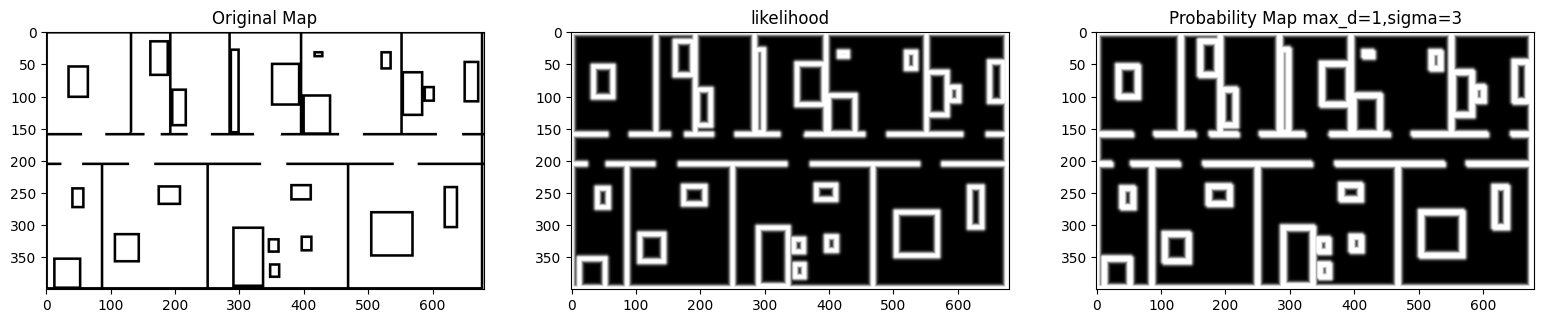

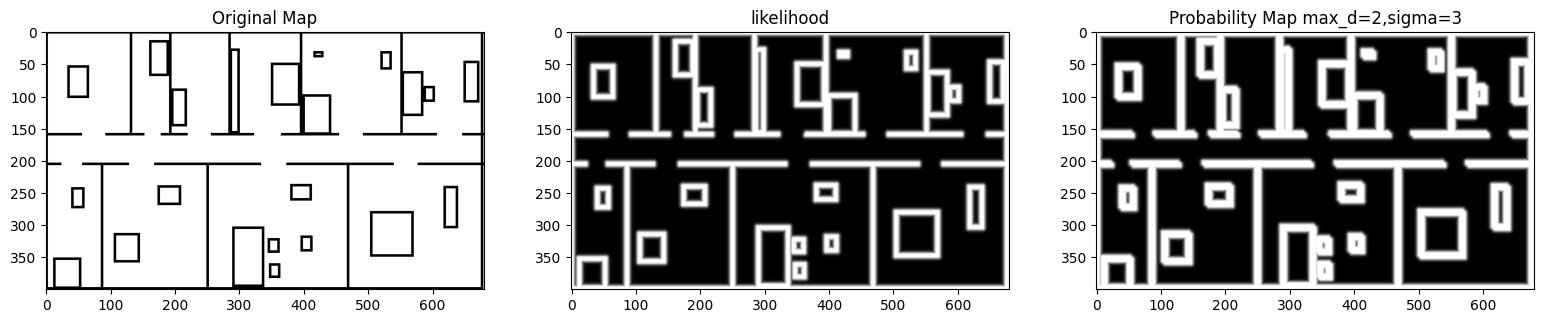

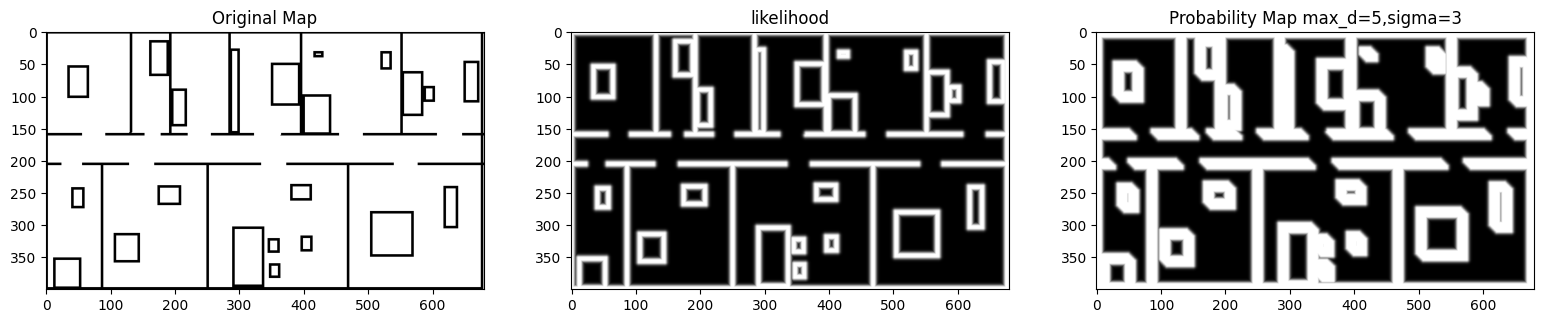

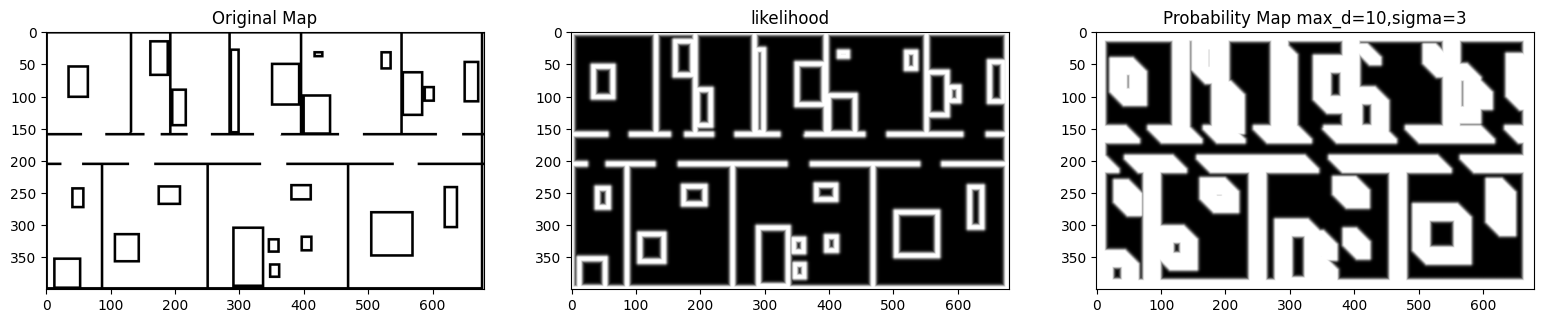

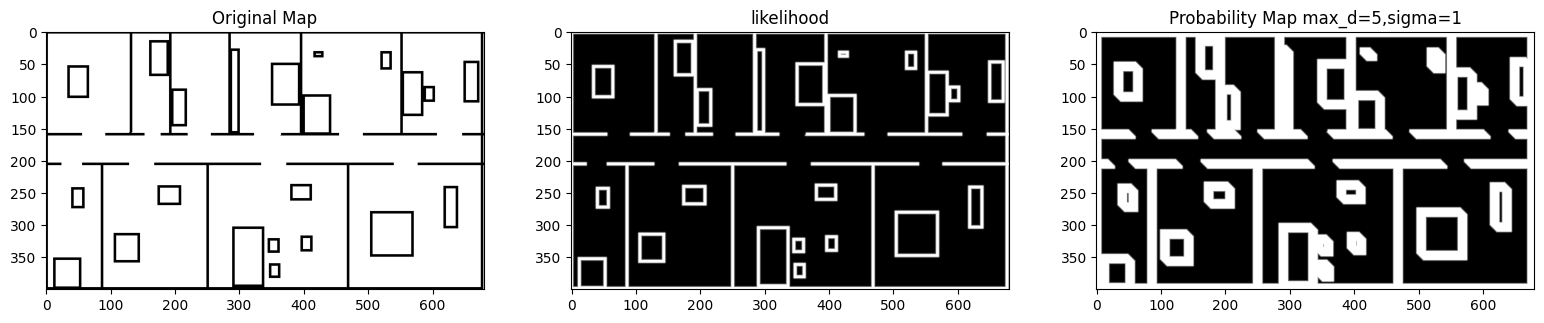

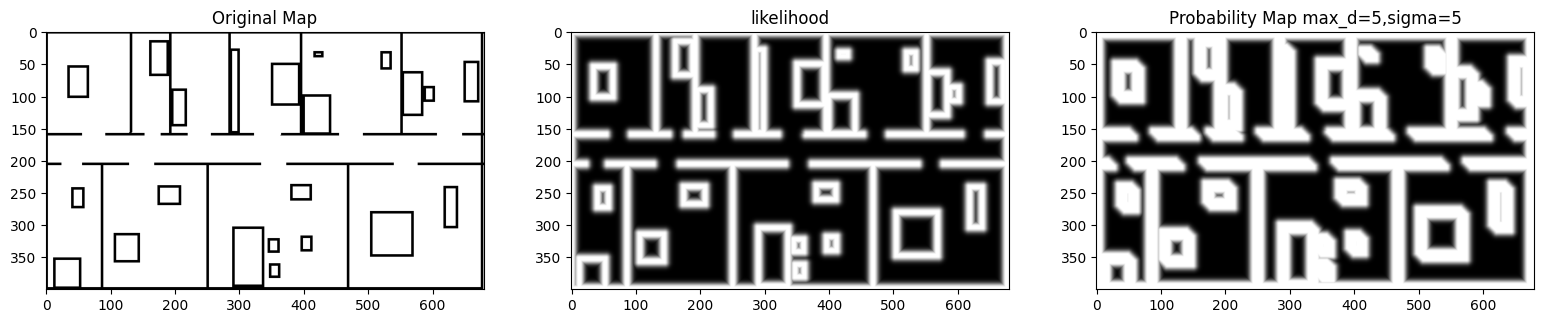

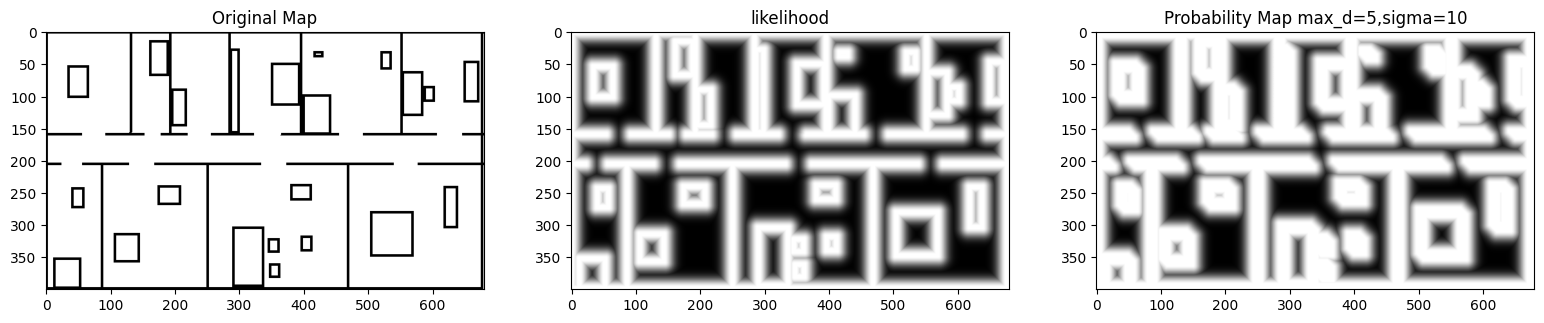

array([[1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002],
       [1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002],
       [1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002],
       ...,
       [1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002],
       [1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002],
       [1.00010002, 1.00010002, 1.00010002, ..., 1.00010002, 1.00010002,
        1.00010002]])

In [ ]:

def highest_likelihood(map,max_ray,sigma=3,ray_angle=1):

    Likelihood = cv2.distanceTransform(map, cv2.DIST_L2, 0)
        
    Likelihood = 1/np.sqrt(2 * np.pi * sigma) * np.exp(-0.5 * ((Likelihood/sigma)**2 ) )
    Likelihood = Likelihood / np.max(Likelihood)

    # Add small no to prevent 0 prop
    Likelihood+=0.0001

    H,W=Likelihood.shape[1],Likelihood.shape[0]

    
    prob_map=np.zeros((W,H))
   

    # Loop Over All Positions
    for x in range(0,W):
        for y in range(0,H):
            # Try each orientation
            p_theta_max=0
            for theta in range(0,360,ray_angle):
                theta_rad = math.radians(theta)
                ray_end_x = math.ceil((x + max_ray * math.cos(theta_rad)))
                ray_end_y = math.ceil((y + max_ray * math.cos(theta_rad)))
        
                # Drop those out of the Map Boundaries
                if(ray_end_x>=W or ray_end_x<0 or ray_end_y>=H or ray_end_y<0):
                    p_endpoint=0.000001 #Very small
                  
                else:
                    p_endpoint=Likelihood[ray_end_x,ray_end_y]

                if(p_endpoint>p_theta_max):
                    p_theta_max=p_endpoint
            # P at pose x,y is the one with the max orientation
            prob_map[x][y]=p_theta_max
                

    # return max_p_pose,p_max
    show_images([map,Likelihood,prob_map],['Original Map','likelihood',f'Probability Map max_d={max_ray},sigma={sigma}'])
    return prob_map


# Search Pose of these readings 
# Different max_distance 
highest_likelihood(map,max_ray=1,sigma=3,ray_angle=1)
highest_likelihood(map,max_ray=2,sigma=3,ray_angle=1)
highest_likelihood(map,max_ray=5,sigma=3,ray_angle=1)
highest_likelihood(map,max_ray=10,sigma=3,ray_angle=1)


# Different Sigmas
highest_likelihood(map,max_ray=5,sigma=1,ray_angle=1)
highest_likelihood(map,max_ray=5,sigma=5,ray_angle=1)
highest_likelihood(map,max_ray=5,sigma=10,ray_angle=1)


# Differ Max_distance and sigmas



# Extra for Problem (1)
After Taking Measurement i can use it to estimate the correct pose of the robot given likelihood

## Generate Likelihood Map

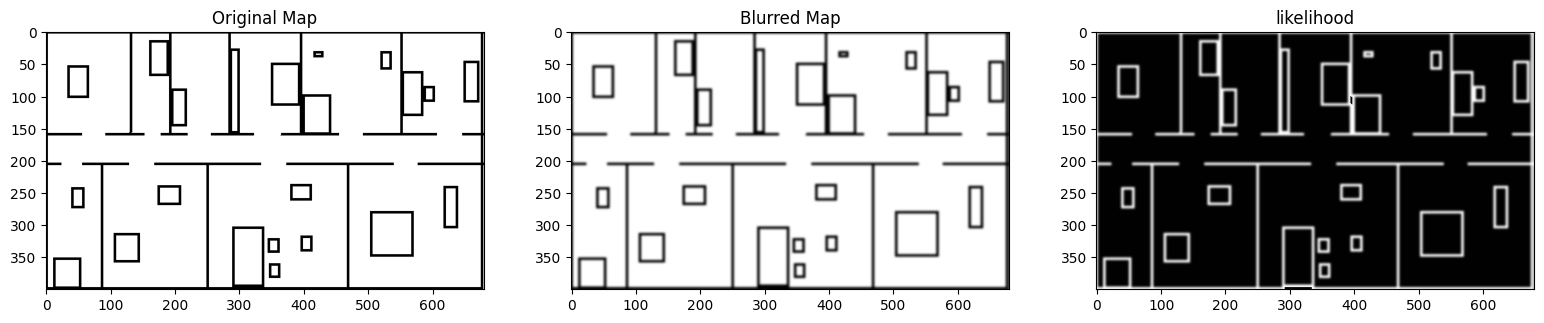

0.0 1.0


In [24]:
# Gaussian Blur for the Map
Blurred_map= cv2.GaussianBlur(map*255, (9, 9), 0)  # Adjust the kernel size as needed

# Get Likelihood Map
likelihood= 255 - Blurred_map  # Adjust the kernel size as needed

# Add 0.01 to prevent zero probability
likelihood+=1
likelihood=likelihood/255.0

show_images([map,Blurred_map,likelihood],['Original Map','Blurred Map','likelihood'])
print(np.min(likelihood),np.max(likelihood))

    

Test P of Correct and incorrect Poses :D


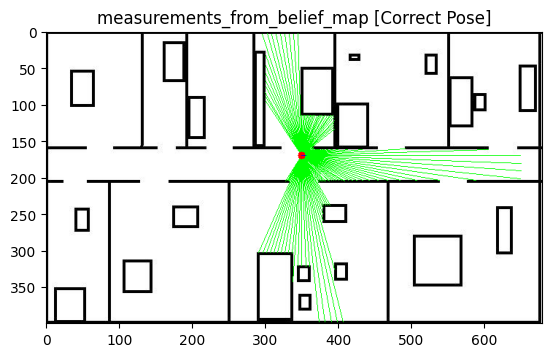

Prob:  7.53317558393134e-41


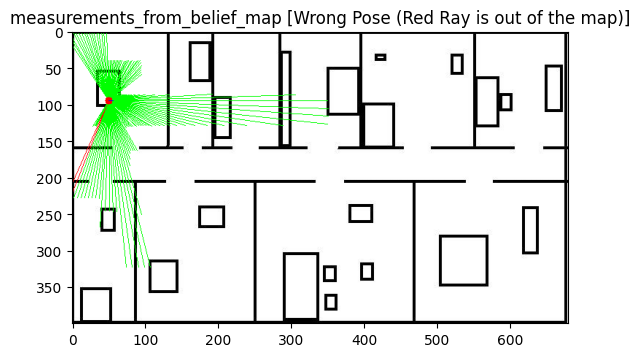

Prob:  1.8508545305549761e-298


In [18]:
def position_probability(map_dim,pose_belief,distances,ray_angle,debug=False,title=""):
    H,W=map_dim[0],map_dim[1]

    measurements_from_belief_map=img.copy()

    x=pose_belief[0]
    y=pose_belief[1]
    theta=pose_belief[2]
    theta_rad = math.radians(-1*theta)

    probability=1
    # Go 125 Degrees right and left on ray_angle=2 degrees at each step
    for index,i in enumerate(range(0,125,ray_angle)):  
            
        # Right
        new_theta_rad = math.radians(-1*theta+i)
        # Calculate the new x and y coordinates
        ray_end_x = math.ceil((x*4 + distances[2*index] * math.cos(new_theta_rad))/4)
        ray_end_y = math.ceil((y*4 + distances[2*index] * math.sin(new_theta_rad))/4)

        if(ray_end_x>=W or ray_end_x<0 or ray_end_y>=H or ray_end_y<0):
            p_endpoint=0.000001 #Very small
            if debug :
                # Draw This Measurement on the believed pose
                cv2.line(measurements_from_belief_map, (x, y), (ray_end_x,ray_end_y), (255,0,0), 1)
        else:
            p_endpoint=likelihood[ray_end_y,ray_end_x]
            if debug :
                # Draw This Measurement on the believed pose
                cv2.line(measurements_from_belief_map, (x, y), (ray_end_x,ray_end_y), (0,255,0), 1)


        # * to the total P
        probability*=p_endpoint


        # Prevent Multiply p of ray at angle 0 from the position of the robot 2 times :D
        if(index==0):
            continue
            

        # Left
        new_theta_rad = math.radians(-1*theta-i)
        # Calculate the new x and y coordinates
        ray_end_x = math.ceil((x + distances[2*index+1] * math.cos(new_theta_rad))/4)
        ray_end_y = math.ceil((y + distances[2*index+1] * math.sin(new_theta_rad))/4)


        # Drop those out of the Map Boundaries
        if(ray_end_x>=W or ray_end_x<0 or ray_end_y>=H or ray_end_y<0):
            p_endpoint=0.000001 #Very small
            if debug :
                # Draw This Measurement on the believed pose
                cv2.line(measurements_from_belief_map, (x, y), (ray_end_x,ray_end_y), (255,0,0), 1)
        else:
            p_endpoint=likelihood[ray_end_y,ray_end_x]
            if debug :
                # Draw This Measurement on the believed pose
                cv2.line(measurements_from_belief_map, (x, y), (ray_end_x,ray_end_y), (0,255,0), 1)

        if debug :
            # Draw This Measurement on the believed pose
            cv2.line(measurements_from_belief_map, (x, y), (ray_end_x,ray_end_y), (0,255,0), 1)


        # * to the total P
        probability*=p_endpoint


    if debug:
        # Draw Belief Robot Pose (x,y)
        cv2.circle(measurements_from_belief_map, (x,y), 5, (255, 0, 0), thickness=-1) # r=4 bec cell is 4*4
        cv2.circle(measurements_from_belief_map, (x,y), 5, (255, 0, 0), thickness=-1) # r=4 bec cell is 4*4

        # Draw theta
        pose_orientation_x = (int)(x + 6 * math.cos(theta_rad))
        pose_orientation_y = (int)(y + 6 * math.sin(theta_rad))
        cv2.line(measurements_from_belief_map, (x, y), (pose_orientation_x, pose_orientation_y), (0,0,255), 1)
        cv2.line(measurements_from_belief_map, (x, y), (pose_orientation_x, pose_orientation_y), (0,0,255), 1)

    if debug:
        show_images([measurements_from_belief_map],['measurements_from_belief_map ['+title+']'])

    return probability

print("Test P of Correct and incorrect Poses :D")
x=350
y=170
theta=0
ray_angle=2

# Get Reading
distances=laser_range(map,(x,y,theta),False)

# Get P of the correct pose
H,W=map.shape
print("Prob: ",position_probability((H,W),pose_belief=(x,y,theta),distances=distances,ray_angle=ray_angle,debug=True,title="Correct Pose"))

# Get P of a far pose
print("Prob: ",position_probability((H,W),pose_belief=(50,95,theta),distances=distances,ray_angle=ray_angle,debug=True,title="Wrong Pose (Red Ray is out of the map)")) 

## Find The Most Probable Pose

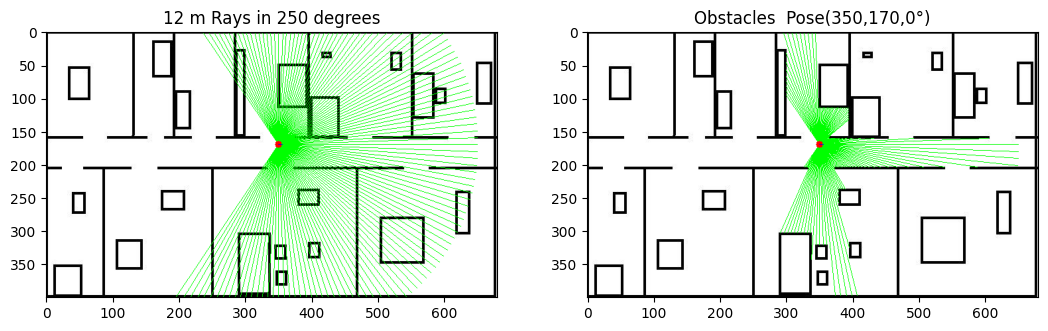

p_max 4.534414012674633e-301 at (5, 220, 20)
p_max 6.000400452975525e-287 at (10, 220, 20)
p_max 3.212127061563667e-285 at (20, 170, 0)
p_max 6.432080943434538e-259 at (25, 170, 0)
p_max 5.849618561962548e-245 at (30, 170, 0)
p_max 1.6424591968500058e-242 at (35, 170, 0)
p_max 9.564316117424138e-195 at (50, 170, 0)
p_max 4.5260023635570486e-191 at (55, 170, 0)
p_max 1.1023797577601575e-180 at (75, 170, 0)
p_max 2.1932491186360317e-167 at (80, 170, 0)
p_max 6.988655569914917e-153 at (85, 170, 0)
p_max 5.331799230847499e-143 at (170, 170, 0)
p_max 1.0186200001807676e-133 at (175, 170, 0)
p_max 5.503282083559331e-131 at (335, 170, 0)
p_max 3.5964495383994797e-115 at (340, 170, 0)
p_max 7.472822781832033e-83 at (345, 170, 0)
p_max 7.53317558393134e-41 at (350, 170, 0)


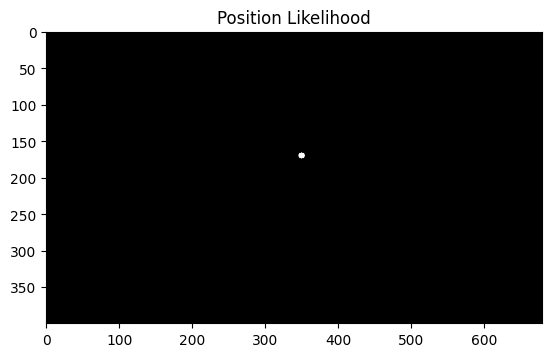

Most P Pose is (350, 170, 0) with P 7.53317558393134e-41


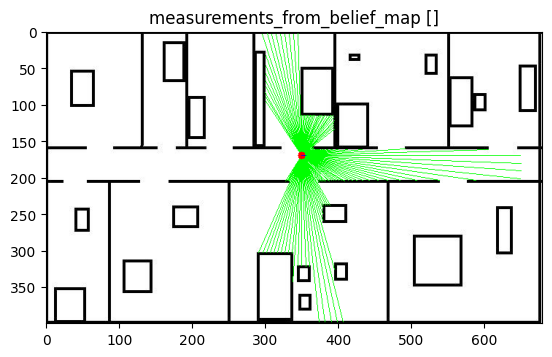

7.53317558393134e-41


((350, 170, 0), 7.53317558393134e-41)

In [ ]:

def Search_Pose(map_dim,distances,ray_angle):
    H,W=map_dim[0],map_dim[1]

    
    # p_max=0
    # max_p_pose=None
    prob_map=np.zeros((H,W))
    # Loop Over All Positions
    for x in range(0,W,5):
        for y in range(0,H,5):
            # Try each orientation
            for theta in range(0,360,10):
                p=position_probability((H,W),pose_belief=(x,y,theta),distances=distances,ray_angle=ray_angle)
                if(p>prob_map[x][y]):
                    # This theta has higher P
                    prob_map[x][y]=p

                if(p>p_max):
                    p_max=p
                    max_p_pose=(x,y,theta)
                    print("p_max",p_max,"at",max_p_pose)

    position_p=np.zeros((map.shape[0],map.shape[1]))
    position_p[max_p_pose[1],max_p_pose[0]]=255




    # Dilate image
    circle_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9 ,9))

    # Dilate the image using the circular structuring element
    dilated_image = cv2.dilate(position_p, circle_kernel)

    show_images([dilated_image],['Position Likelihood'])
    print("Most P Pose is",max_p_pose,"with P",p_max)
    print(position_probability((H,W),pose_belief=(max_p_pose),distances=distances,ray_angle=ray_angle,debug=True))

    return max_p_pose,p_max

x=350
y=170
theta=0
ray_angle=2
# Get Reading
distances=laser_range(map,initial_pose=(x,y,theta),debug=False)

# Search Pose of these readings 
Search_Pose(map_dim=map.shape,distances=distances,ray_angle=ray_angle)

